In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import itertools

import torch
import numpy as np
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
# import rali_pybind.tensor
import sys
import cv2
import os
from math import sqrt
import ctypes
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import matplotlib.patches as patches
import torchvision.transforms.functional as TF

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-01 11:53:34.739754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 11:53:34.990774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/opt/ompi/lib:/opt/rocm/lib:/usr/local/lib:
2023-06-01 11:53:34.990827: I tensorflow/compiler/xla/

In [7]:
class ROCALCOCOIterator(object):
    """
    COCO ROCAL iterator for pyTorch.
    Parameters
    ----------
    pipelines : list of amd.rocal.pipeline.Pipeline
                List of pipelines to use
    size : int
           Epoch size.
    """

    def __init__(self, pipelines, tensor_layout=types.NCHW, reverse_channels=False, multiplier=None, offset=None, tensor_dtype=types.FLOAT, device="cpu", display=False, num_anchors=8732, pixelwise_mask=False, select_mask_id=[0], polygon_mask=False):

        try:
            assert pipelines is not None, "Number of provided pipelines has to be at least 1"
        except Exception as ex:
            print(ex)
        self.loader = pipelines
        self.tensor_format = tensor_layout
        self.multiplier = multiplier if multiplier else [1.0, 1.0, 1.0]
        self.offset = offset if offset else [0.0, 0.0, 0.0]
        self.reverse_channels = reverse_channels
        self.tensor_dtype = tensor_dtype
        self.device = device
        self.device_id = self.loader._device_id
        self.bs = self.loader._batch_size
        self.num_anchors = num_anchors
        self.display = True
        self.pixelwise_mask = pixelwise_mask
        self.polygon_mask = polygon_mask
        self.select_mask_id = select_mask_id

        #Image id of a batch of images
        self.image_id = np.zeros(self.bs, dtype="int32")
        # Count of labels/ bboxes in a batch
        self.bboxes_label_count = np.zeros(self.bs, dtype="int32")
        # Image sizes of a batch
        self.img_size = np.zeros((self.bs * 2), dtype="int32")
        #print("INIT exit")

    def next(self):
        return self.__next__()

    def __next__(self):
        if(self.loader.isEmpty()):
            raise StopIteration
        if self.loader.rocalRun() != 0:
            raise StopIteration
        else:
            self.output_tensor_list = self.loader.rocalGetOutputTensors()

        #From init

        self.lis = []  # Empty list for bboxes
        self.lis_lab = []  # Empty list of labels
        self.w = self.output_tensor_list[0].batch_width()
        self.h = self.output_tensor_list[0].batch_height()
        self.bs = self.output_tensor_list[0].batch_size()
        self.color_format = self.output_tensor_list[0].color_format()

        torch_gpu_device = torch.device('cuda', self.device_id)

        #NHWC default for now
        self.out = torch.empty((self.bs, self.h, self.w, self.color_format,), dtype=torch.float32, device=torch_gpu_device)
        self.output_tensor_list[0].copy_data(ctypes.c_void_p(self.out.data_ptr()))

        # 1D labels & bboxes array
        bbox_cpu = self.loader.rocalGetBoundingBoxCords()
#         bbox_cpu = self.loader.rocalGetBoundingBoxCords()
#         bbox_arr = torch.as_tensor(bbox_cpu, dtype=torch.float32, device=torch_gpu_device)
        label_cpu = self.loader.rocalGetImageLabels()
        # label_arr = torch.as_tensor(label_cpu, dtype=torch.int32, device=torch_gpu_device)
        pixelwiselabel_cpu = self.loader.rocalGetPixelwiseLabels()
        # if pixelwiselabels = True
        if self.pixelwise_mask == True:
            random_mask_pixel_cpu = self.loader.rocalRandomMaskPixel()
        elif self.polygon_mask == True:
            num_objects_per_batch = self.loader.rocalGetBoundingBoxCount()
            mask_count_array = np.zeros(num_objects_per_batch, dtype="int32")
            total_mask_count_per_batch = self.loader.rocalGetMaskCount(mask_count_array)
            polygon_size_array = np.zeros(total_mask_count_per_batch, dtype="int32")
            mask_coordinates_list = self.loader.rocalGetMaskCoordinates(polygon_size_array, mask_count_array)
            self.select_mask_id = [0] #Given by the user
            select_mask_array = self.loader.rocalSelectMask(self.select_mask_id)

        # Image id of a batch of images
        self.loader.GetImageId(self.image_id)
        # Image sizes of a batch
        self.loader.GetImgSizes(self.img_size)
        image_id_tensor = torch.tensor(self.image_id, device=torch_gpu_device)
        image_size_tensor = torch.tensor(self.img_size, device=torch_gpu_device).view(-1, self.bs, 2)

        if self.pixelwise_mask == True:
            return self.out, bbox_cpu, label_cpu, pixelwiselabel_cpu, random_mask_pixel_cpu
        elif self.polygon_mask == True:
            return self.out, bbox_cpu, label_cpu, pixelwiselabel_cpu, select_mask_array
        else:
            return self.out, bbox_cpu, label_cpu, pixelwiselabel_cpu

    def reset(self):
        self.loader.rocalResetLoaders()

    def __iter__(self):
        return self

def draw_patches(img, idx, bboxes, device):
    #image is expected as a tensor, bboxes as numpy
    import cv2
    if device == "cpu":
        image = img.detach().numpy()
    else:
        image = img.cpu().numpy()
    htot, wtot, _ = img.shape

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for (xc, yc, w, h) in bboxes:
        l = xc - 0.5*(w)
        t = yc - 0.5*(h)
        r = xc + 0.5*(w)
        b = yc + 0.5*(h)
        loc_ = [l, t, r, b]
        color = (255, 0, 0)
        thickness = 2
        image = cv2.UMat(image).get()
        image = cv2.rectangle(image, (int(loc_[0]*wtot), int(loc_[1] * htot)), (int(
            (loc_[2] * wtot)), int((loc_[3] * htot))), color, thickness)
        cv2.imwrite("OUTPUT_IMAGES_PYTHON/NEW_API/COCO_READER/" + str(idx)+"_"+"train"+".png", image)


In [8]:
def draw_patches_1(img, idx, device):
    if device == "cpu":
        image = img.detach().cpu().numpy()
    else:
        image = img.cpu().numpy()
    image = (image).astype('uint8')
    return image 

In [9]:
def plotting_labels(image_labels,idx,device):
    image_labels = [image_labels[i:i+640] for i in range(0, 307200, 640)]
    cmap = plt.get_cmap('tab10', np.max(image_labels) + 1)
    new_cmap = mcolors.ListedColormap(cmap.colors)
    new_cmap.colors[4] = mcolors.to_rgba(cmap.colors[4], alpha=0.5) 
    label_image = new_cmap(image_labels)
    plt.imshow(label_image)
    plt.axis('off')
    plt.show()

In [10]:
    image_path = "/media/develop/MIVisionX-data/rocal_data/coco/coco_10_img/train_10images_2017/"
    annotation_path = "/media/develop/MIVisionX-data/rocal_data/coco/coco_10_img/annotations/instances_train2017.json"
    _rali_cpu = True
    batch_size = 10
    num_threads = 1
    device_id = 0
    random_seed = 11
    crop_width=640
    crop_height=480
    crop=300
    local_rank = 0
    world_size = 1
    rali_device = 'cpu'
    decoder_device = 'cpu'
    device_memory_padding = 211025920 if decoder_device == 'mixed' else 0
    host_memory_padding = 140544512 if decoder_device == 'mixed' else 0


Pipeline has been created succesfully
polyyyyyyyyyy True
OK: loaded 90 kernels from libvx_rpp.so
POLYGON MASK
*********************** SHARD ID ************************ 0
*********************** NUM SHARDS ********************** 1
+++++++++++++++++++++++++++++EPOCH+++++++++++++++++++++++++++++++++++++ 0
************************************** i ************************************* 0


Comes to the PYBIND CALL

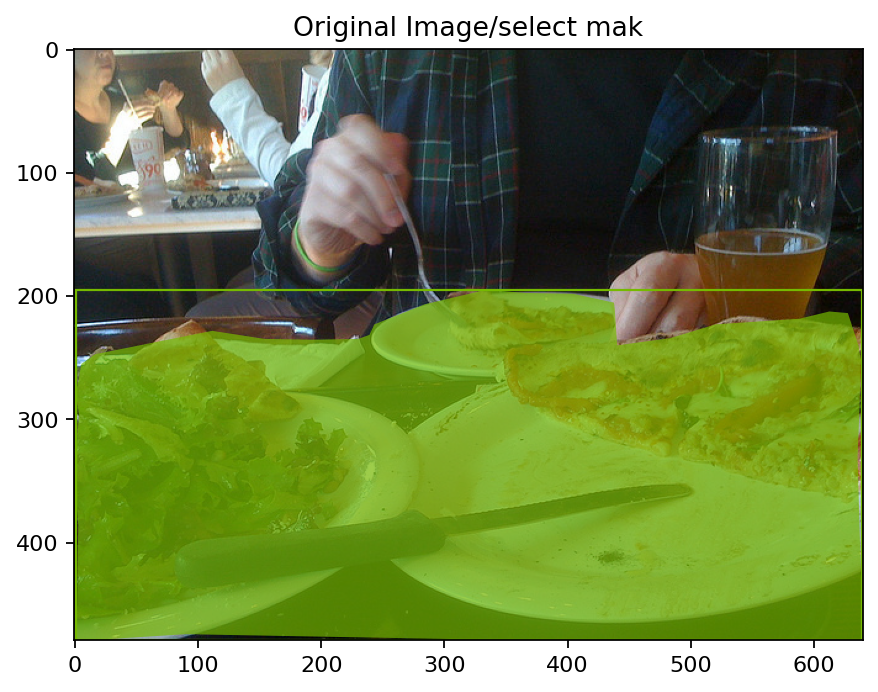

*********************************************************************


In [12]:
coco_train_pipeline = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=random_seed, rocal_cpu=_rali_cpu)
pixelwise_mask = False # pixelwise_mask & polygon_mask are mutually exclusive
polygon_mask = True # pixelwise_mask & polygon_mask are mutually exclusive
with coco_train_pipeline:
    if pixelwise_mask == True:
        jpegs, bboxes, labels, pixelwisemaks = fn.readers.coco(file_root=image_path, annotations_file=annotation_path, pixelwise_mask = True, random_shuffle=False, shard_id=local_rank, num_shards=world_size,seed=random_seed, is_box_encoder=False, is_foreground=True, polygon_mask=False)
    if polygon_mask == True:
        jpegs, bboxes, labels, polygonmask = fn.readers.coco(file_root=image_path, annotations_file=annotation_path, pixelwise_mask = False, random_shuffle=False, shard_id=local_rank, num_shards=world_size,seed=random_seed, is_box_encoder=False, is_foreground=False, polygon_mask=True)
    else:
        jpegs, bboxes, labels = fn.readers.coco(file_root=image_path, annotations_file=annotation_path, pixelwise_mask = False, random_shuffle=False, shard_id=local_rank, num_shards=world_size,seed=random_seed, is_box_encoder=False, is_foreground=False, polygon_mask=False)

    print("*********************** SHARD ID ************************",local_rank)
    print("*********************** NUM SHARDS **********************",world_size)
    images_decoded = fn.decoders.image(jpegs, file_root=image_path, output_type=types.RGB, shard_id=0, num_shards=1, random_shuffle=False, annotations_file=annotation_path)
    res_images = fn.resize(images_decoded, device=rali_device, resize_width=crop_width, resize_height=crop_height, rocal_tensor_layout = types.NHWC, rocal_tensor_output_type = types.UINT8)
    images = fn.crop_mirror_normalize(res_images, device="cpu",
                                        crop=(crop_height, crop_width),
                                        image_type=types.RGB,
                                        mirror=0,
                                        rocal_tensor_layout = types.NHWC,
                                        rocal_tensor_output_type = types.FLOAT,
                                        mean=[0,0,0 ],
                                        std=[1,1,1 ])

    coco_train_pipeline.set_outputs(images)
coco_train_pipeline.build()
COCOIteratorPipeline = ROCALCOCOIterator(coco_train_pipeline, pixelwise_mask=pixelwise_mask, select_mask_id=[0], polygon_mask=polygon_mask)
cnt = 0
fig, ax = plt.subplots(dpi=160)
W=640
H=480
for epoch in range(1):
#         i=2
    print("+++++++++++++++++++++++++++++EPOCH+++++++++++++++++++++++++++++++++++++",epoch)
    for i , it in enumerate(COCOIteratorPipeline):
        print("************************************** i *************************************",i)
#         i=8
#         print("val of i ", i )
        labels_array=it[3]
        img=it[0][i]
        ax.imshow(draw_patches_1(img, cnt, "cpu"))
        image = it[0][i]
        mask = it[4][i]["0"]
        bbox= it[1][i]
#         print("bounding box shape ", len(bbox))
        bbox_list = [list(item) for item in bbox]
        output_array = np.array(bbox_list)
        l, t, r, b = output_array[0] * [W, H, W, H] 
#         print(l, t, r, b)
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax.add_patch(rect)
        polygon_vertices = [mask[k:k+2] for k in range(0, len(mask), 2)]
#         print( "polygon_vertices ",polygon_vertices)
        ax.imshow(draw_patches_1(img,cnt,"cpu"))
        poly = patches.Polygon(polygon_vertices, True, facecolor='#76b900', alpha=0.7)
        ax.add_patch(poly)
        plt.title('Original Image/select mak')
        plt.show()
    COCOIteratorPipeline.reset()
print("*********************************************************************")